# Barrents sea - Producer Notebook

## Introduction 

This Notebook provides guidance and support for data processing of Conductivity Temperature Depth (CTD) measurements from instruments onboard of research vessels, and acquired from 1991 to 2020.  

The data access relies on queries to remote OPeNDAP servers hosting the CTD data, and the data processing makes use of the Geostatistical Library (RIntaros / RGeostats) for the modelisation of geostatistical relationships between variables, and to interpolate gridded data maps out of irregular CTD point measurements.

## Objective
This Notebook is targeted to a producer, who has a specific goal in mind: producing a 2D map of *temperature* at a given depth, within a given bounding box and time interval, at a specified resolution. 

## Required Input Parameters
At the beginning of this notebook, the user is prompted to enter the following input parameters:
* **Depth**: the depth value of interest;  
* **Bounding Box**: the longitude and latitude boundaries of interest;
* **Time Range**: the month and year of interest; and
* **Mesh**: the longitude and latitude resolution of the final map.  

## Additional Information
The CTD data access point is configured for the OPeNDAP Hyrax server operated by the Institute of Marine Research, Norwegian Marine Data Centre, Norway
http://opendap1.nodc.no/opendap/physics/point/yearly/contents.html

Note: for this server, the **.nc4** extension from the data access URLs is not supported.

The multi-year selection for CTD campaigns at sea is supported via the **year** parameter in the *fetch_data(url, year)* function in *helpers.py*, and consequently all the *fetch_data(url, year)* function calls within the Notebook. 

Citation: refer to the EC INTAROS project: https://cordis.europa.eu/project/id/727890.

More information on the RGeostats package is available on: http://rgeostats.free.fr/.

# User-defined Input Parameters
These are the required input parameters that the user must define for the analysis, keeping in mind the goal of this notebook to **generate a temperature map at a given depth, and at a given time, and within given geographical boundaries**

## Import Libraries

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import os
# from pyproj import Transformer

from helpers import *

# from bokeh.plotting import figure, output_file, show, ColumnDataSource
# from bokeh.models import HoverTool, WheelZoomTool, BoxZoomTool, ResetTool, PanTool
# from bokeh.io import output_notebook
# from bokeh.tile_providers import OSM, get_provider

from datetime import datetime, timedelta
import calendar

from lxml import html
import requests

## Depth

In [2]:
# User-defined Depth (in meters)
while True:
    try:
        depth = int(input('Insert the desired Depth (integer, in meters): ')) #20
        break
    except ValueError:
        print("Error. Value must be integer, insert again.")
        continue

# Apply margins
depth1 = int(applyMargin(depth, f='low'))
depth2 = int(applyMargin(depth, f='high'))

# Display
print(f'User-defined Depth: {depth} meters')
print(f'Depth range (including margins): {depth1} - {depth2}')

Insert the desired Depth (integer, in meters):  40


User-defined Depth: 40 meters
Depth range (including margins): 32 - 48


## Bounding Box (BBOX)
The BBOX boundaries must be entered in geographic coordinates (WGS84).

Format to use: minLong, maxLong, minLat, maxLat (eg: -4, 18, 42, 72) 

In [3]:
# User-defined bbox label and boundaries
bbox_key = 'UserAOI' # bbox label
bbox_usr = input('Insert the desired Bounding Box\n(in the format: minLong, maxLong, minLat, maxLat, eg: -5, 15, 53, 60): ') # [-5, 15, 53, 60] # bbox boundaries, in the format: minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80] 
bbox_usr = [int(i) for i in bbox_usr.split(', ')] # convert string to array of integers

# Apply margins
bbox0 = int(applyMargin(bbox_usr[0], f='low'))
bbox1 = int(applyMargin(bbox_usr[1], f='high'))
bbox2 = int(applyMargin(bbox_usr[2], f='low'))
bbox3 = int(applyMargin(bbox_usr[3], f='high'))
bbox_values = [bbox0, bbox1, bbox2, bbox3]
bbox_dict = {}
bbox_dict[bbox_key] = bbox_values

# Display
print(f"User-defined BBOX='{bbox_key}': {bbox_usr}")
print(f'BBOX range (including margins) WGS84: {bbox_dict[bbox_key]}')

# Reproject BBOX to Web-Mercator
proj_wgs84 = "epsg:4326"
proj_webm = "epsg:3857"
bbox_reprj_lat, bbox_reprj_long = reproject(proj_wgs84, 
                                            proj_webm, 
                                            bbox_values[2:], # latitude first
                                            bbox_values[:2]) # then longitude
bbox_repj = list(np.array([bbox_reprj_lat, bbox_reprj_long]).flatten())

# Update bbox_dict
bbox_dict[bbox_key] = bbox_repj

print(f'BBOX range (including margins) Web-Mercator: {bbox_dict[bbox_key]}')

Insert the desired Bounding Box
(in the format: minLong, maxLong, minLat, maxLat, eg: -5, 15, 53, 60):  -5, 15, 53, 60


User-defined BBOX='UserAOI': [-5, 15, 53, 60]
BBOX range (including margins) WGS84: [-4, 18, 42, 72]
BBOX range (including margins) Web-Mercator: [-445277.96317309426, 2003750.8342789242, 5160979.444049781, 11753184.615338452]


## Time Range

In [4]:
# User-defined Month of interest start and end date in the format [day,month,year]
while True:
    mmyyyy = input('Insert the month and year of interest (in the format MMYYYY): ') 
    
    if len(mmyyyy) != 6: continue
    
    year = mmyyyy[2:]
    month = mmyyyy[:2].strip()
    
    try:
        year = int(year)
        month = int(month)
        
        if ((year < 1990) or (year > 2020)): 
            print('Error: available data ranges between 1991 and 2020. Type Year within this range.')
            continue
            
        break
        
    except ValueError:
        print("Error digits must be integer in the MMYYY format, eg for January 2010 --> type 012010.")
        continue

# Apply Margin
if month == 1:
    month1 = 12
    month2 = month+1
    year1 = year-1
    year2 = year
elif month == 12:
    month1 = month-1
    month2 = 1
    year1 = year
    year2 = year+1
else:
    month1 = month-1
    month2 = month+1
    year1 = year2 = year

day_start = 1
day_end = calendar.monthrange(year2, month2)[1] # only used for the last day of month

time_start = datetime(year1, month1, day_start)
time_end = datetime(year2, month2, day_end)

# Display
# time_filter_str = f'{time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}'
time_filter_str = f'{time_start.strftime("%m%Y")}-{time_end.strftime("%m%Y")}'
print(f'User-defined Month: {datetime(year, month,1).strftime("%Y-%m")}')
print(f'Time range (including margins): {time_filter_str}')

Insert the month and year of interest (in the format MMYYYY):  102003


User-defined Month: 2003-10
Time range (including margins): 092003-112003


## Mesh

In [5]:
# User-define mesh (in degrees, equal for both long and lat)
while True:
    try:
        mesh = int(input('Insert the resolution mesh (long and lat res. of the final map, in degree, eg 1): ') )
        break
    
    except ValueError:
        print("Error. Value must be integer, insert again.")
        continue

# Display
print(f'User-defined Mesh: {mesh} degree')

Insert the resolution mesh (long and lat res. of the final map, in degree, eg 1):  1


User-defined Mesh: 1 degree


# Extraction of NetCDF Data

## Exploratory Data Analysis

### Set-up

#### Server URL
We select the OPeNDAP NMDC server where CTD datasets are hosted for our Arctic region of interest: http://opendap1.nodc.no/opendap/physics/point/yearly/.

The first thing is to get an understanding of the server content (exploring the URL within a browser), in particular the years of the campaings at sea, the naming convention for the "platforms" (i.e. the research vessels), the variables and attributes that are available.

In [6]:
# URL of Norwegian Marine Data Centre (NMDC) data server
nmdc_url = 'http://opendap1.nodc.no/opendap/physics/point/yearly/' 

# URL of Terradue Cloud Platform Hyrax server
# Ellip user account and VPN setup required
t2_hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/'

urls = {}
urls['nmdc'] = [nmdc_url, '']
urls['t2_hyrax'] = [t2_hyrax_url, '.nc4']

#========================================================
# Define below the URL to use (either 'nmdc' or 't2_hyrax'):
url_info = urls['t2_hyrax']
#========================================================

print('Server URL and URL suffix:', url_info)

Server URL and URL suffix: ['https://opendap.terradue.com/hyrax/data/subset_2003/', '.nc4']


### Retrieval of DDS info
The OPeNDAP's Dataset Descriptor Structure (DDS) delivers lightweight information, useful for the application developer to visually analyse and understand the dataset at hand (geographic and temporal extends covered, and eventual data gaps).  

Accessing the data using the DDS info we retrieve the dimensions of the data for: **TIME**, **LATITUDE**, **LONGITUDE**, **DEPTH**.

In [7]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

# get all content of the server_url, and then filter it with year and available platforms
page = requests.get(url_info[0])
webpage = html.fromstring(page.content)

urls_filtered = [p for p in webpage.xpath('//a/@href') if p.endswith(f'{year}.nc{url_info[1]}.dds')]

for u in urls_filtered:
    
    dds = f'{url_info[0]}/{u}'; print(dds)
    
    # Find platform code
    if len(url_info[1]) == 0: pc = dds.split('_')[0][-2:] # nmdc case
    else: pc = dds.split('_')[1][-2:] # t2_hyrax case
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

assert depth_stop_dict.keys() == time_stop_dict.keys(), 'TIME and DEPTH Keys error. Please check.'

print(f'\nSelected DEPTH value ({depth}m) and relative range ({depth1}-{depth2}m)')
# Extract all platform_codes
platform_codes = [kd for kd in depth_stop_dict.keys()]
print(f'Available platforms in given year {year}: {platform_codes}')

# Now remove platforms that have DEPTH range lower than the user-specific desired DEPTH, as it does not hold useful information for the user-specific DEPTH analysis
for pc in depth_stop_dict.keys():
    if depth2 > depth_stop_dict[pc]: platform_codes.remove(pc) 
print(f'Within desired DEPTH range ({depth1}-{depth2}m): {platform_codes}')

# Print dimensions
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

# Raise an error if there are no platforms left (ie the user-specific DEPTH value is too high for all available platforms / measurements)
if len(platform_codes) == 0:
    sys.exit(f'ERROR: the defined DEPTH value ({depth}m) and relative range ({depth1}-{depth2}m) is too high and there are no available measurements at that DEPTH.\nPlease restart the Notebook with a lower DEPTH value.')

https://opendap.terradue.com/hyrax/data/subset_2003//58AA_CTD_2003.nc.nc4.dds
https://opendap.terradue.com/hyrax/data/subset_2003//58GS_CTD_2003.nc.nc4.dds
https://opendap.terradue.com/hyrax/data/subset_2003//58GT_CTD_2003.nc.nc4.dds
https://opendap.terradue.com/hyrax/data/subset_2003//58HJ_CTD_2003.nc.nc4.dds
https://opendap.terradue.com/hyrax/data/subset_2003//58JH_CTD_2003.nc.nc4.dds

Selected DEPTH value (40m) and relative range (32-48m)
Available platforms in given year 2003: ['AA', 'GS', 'GT', 'HJ', 'JH']
Within desired DEPTH range (32-48m): ['AA', 'GS', 'GT', 'HJ', 'JH']
TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


### Visual Analysis: Load and Plot Positions only
The objective of this section is figure out the shape and extent of the data points (positions) available from the server within that specified year. 

This is well supported by using the lightweight information retrieved from the DDS. The key dimensions that are used for the positions analysis are: **TIME**, **LATITUDE**, **LONGITUDE**.

#### Create Position_Dict (*position_dict*)
We create a dictionary for the positions (the nominal space and time position of an observation) in order to support the optimisation of remote queries to the OPeNDAP server. 
The creation of this dictionary, based on the OPeNDAP DDS lightweight information, is computationally very efficient.

In [8]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url, year)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58JH_CTD_2003.nc.nc4?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


#### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**LONGITUDE** and **LATITUDE**) and respective **TIME** for all platforms, in order to plot and visualise them.

In [9]:
# Load locations (long & lat) and TIME of ALL measurements
start_date = datetime(1950, 1, 1)
    
position_df_raw = pd.DataFrame() 

for key in position_dict.keys():
    tmp = pd.DataFrame()
    
    tmp['Longitude_WGS84'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    tmp['Latitude_WGS84'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    tmp['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    tmp['Platform'] = key
    
    # Convert TIME from float to datetime
    tmp['Time'] = [start_date + timedelta(t) for t in tmp.loc[:,'Time']]
    length = len(tmp[tmp['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(tmp.tail())
    
    position_df_raw = position_df_raw.append(tmp) 
    
position_df_raw['Index_ABS'] = np.arange(0,len(position_df_raw))
position_df_raw = position_df_raw.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df_raw)} measurement locations')
position_df_raw

Platform AA: 684 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude_WGS84,Latitude_WGS84,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Remove Duplicates 
Sometimes, due to the conditions at sea, sensors can generate duplicated information. Duplicates are found based on the *Time* field, and removed from the dataframe to avoid duplication of information.

In [10]:
# Check if there are duplicates
duplicates = position_df_raw[position_df_raw.duplicated(subset='Time') == True]

# Drop duplicates 
position_df = position_df_raw.drop_duplicates(subset=['Time'])

print(f'All Positions: \t\t{len(position_df_raw)} \n\
Duplicates: \t\t{len(duplicates)} / {len(position_df_raw)} \n\
Remaining: \t\t{len(position_df)} / {len(position_df_raw)}')

display(position_df)

All Positions: 		3209 
Duplicates: 		0 / 3209 
Remaining: 		3209 / 3209


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


#### Plot Histogram of measurements of the given year
Next, we quickly figure out if there are some data measurements discrepancies across the different months.

<AxesSubplot:title={'center':'Histogram of available measurements in 2003'}, xlabel='Month', ylabel='Frequency'>

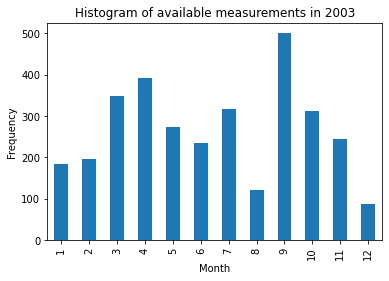

In [11]:
position_df['Time'].groupby(position_df["Time"].dt.month).count().plot(kind="bar", 
                                                               title=(f'Histogram of available measurements in {year}'),
                                                               xlabel='Month',
                                                               ylabel='Frequency')

#### Convert to Web-Mercator for Plotting
Convert longitude and latitude to the Web-Mercator projection, which is needed to generate an interactive plot. 

In [12]:
# Reproject positions in the position_df dataframe
position_df['Longitude'], position_df['Latitude'] = reproject(proj_wgs84, 
                                                              proj_webm, 
                                                              position_df['Latitude_WGS84'], # latitude 
                                                              position_df['Longitude_WGS84']) # longitude
position_df

,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07


#### Plot Positions
Plot locations on an interactive plot, color-coded by platform of acquisition. The plot allows you to:
* hoover your mouse on a point to see platform, longitude and latitude 
* pan across the map 
* zoom by selection box
* zoom in and out 
* reset plot to starting view
* toggle off / on positions of specific platforms by clicking on respective names on the legend 

In [49]:
# Plot all locations (in Web Mercator projection)
xlim = (min(position_df['Longitude'])-1, max(position_df['Longitude'])+1)
ylim = (min(position_df['Latitude'])-1, max(position_df['Latitude'])+1)
title = f'All measurement points, Projection: {proj_webm}'
plotInteractive(position_df, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict=False)

Loading BokehJS ...

Based on the interactive plot above, we can reflect on the distribution of the available data, in order to anticipate the effect of applying filters for optimising the data retrieval.

Some filtering decisions can be made, for example, on the bounding box of interest, the platforms to be selected, and the time range. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the **LATITUDE**, **LONGITUDE** and **TIME** dimensions. First, the data is filtered by bounding box (BBOX). Subsequently, this data is further filtered using a time range.

#### Filter by BBOX

In [50]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox_repj[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox_repj[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox_repj[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox_repj[3])]

print(f'BBOX={bbox_key} range (including margins): {bbox_repj}')
sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(position_df_bbox)

title = f'Filtered data: BBOX={bbox_key}'
plotInteractive(position_df_bbox, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict=bbox_dict)

BBOX=UserAOI range (including margins): [-445277.96317309426, 2003750.8342789242, 5160979.444049781, 11753184.615338452]
Selected positions (out of available positions): 1745 out of 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0,5.137951e+05,8.569851e+06
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1,4.951825e+05,8.568256e+06
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2,4.770374e+05,8.568986e+06
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3,4.583024e+05,8.568143e+06
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4,4.394337e+05,8.569146e+06
...,...,...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204,1.747326e+06,1.148968e+07
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205,1.392128e+06,1.148924e+07
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206,1.447743e+06,1.166426e+07


Loading BokehJS ...

#### Filter by BBOX, adding Time Range filter

In [51]:
position_df_bbox_timerange = position_df_bbox.loc[(position_df_bbox['Time']>=time_start) & 
                                                  (position_df_bbox['Time']<=time_end)]

print(f'BBOX={bbox_key} range (including margins): {bbox_values}')
print(f'Time range (including margins): {time_filter_str}')
sel_outof_all = f'{len(position_df_bbox_timerange)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox_timerange)

title = f'Filtered data: BBOX={bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim, ylim, bbox_dict=bbox_dict)

BBOX=UserAOI range (including margins): [-4, 18, 42, 72]
Time range (including margins): 092003-112003
Selected positions (out of available positions): 456 out of 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
535,8.1725,63.068802,2003-10-16 23:33:12,AA,535,909758.500290,9.117141e+06
536,8.1345,63.105801,2003-10-17 06:11:56,AA,536,905528.347749,9.126241e+06
537,8.1028,63.127300,2003-10-17 06:55:18,AA,537,901999.611106,9.131533e+06
538,8.1013,63.127998,2003-10-17 13:35:48,AA,538,901832.617432,9.131705e+06
539,8.3798,62.953201,2003-10-17 22:52:00,AA,539,932835.051454,9.088785e+06
...,...,...,...,...,...,...,...
920,6.1065,62.445301,2003-11-06 02:16:06,JH,3179,679772.487090,8.965511e+06
921,5.9402,62.088299,2003-11-06 08:54:05,JH,3180,661260.022734,8.880110e+06
922,5.4093,63.031502,2003-11-06 23:08:57,JH,3181,602160.504902,9.107979e+06


Loading BokehJS ...

#### Print or Export Filtered Positions
Uncomment the rows below if you want to display or export to CSV the filtered dataframe.

In [16]:
# # Print filtered dataframe
# pd.set_option('display.max_rows', None)
# display(position_df_bbox_timerange)

# # Save dataframe to csv
# data_output = os.path.join(os.getcwd(), 'data_output')
# if not os.path.exists(data_output): os.mkdir(data_output)
# csvname = os.path.join(data_output, f'filtered_{pc}_df.csv')
# position_df_bbox_timerange.to_csv(csvname, sep=',', header=True)

#### Zoom in on Filtered Positions
Plot filtered positions with the relavite extent of those positions only.

In [52]:
xlim_small = (min(position_df_bbox_timerange['Longitude'])-1, max(position_df_bbox_timerange['Longitude'])+1)
ylim_small = (min(position_df_bbox_timerange['Latitude'])-1, max(position_df_bbox_timerange['Latitude'])+1)
title = f'Filtered data: {bbox_key} and Time={time_filter_str}'
plotInteractive(position_df_bbox_timerange, title, 'Longitude', 'Latitude', xlim_small, ylim_small)

Loading BokehJS ...

#### Define Filtered Dataframe (*df_toPlot*) to be used for online querying of the filtered positions
Define the filtered dataframe (eg *position_df_bbox*, *position_df_bbox_timerange*), to be named **df_toPlot**, and the dictionary of indices of filtered data (to be named **index_dict**), to use for further filtering.

In [18]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox_timerange # or position_df / position_df_bbox

sel_outof_all = f'{len(df_toPlot)} / {len(position_df)}.'

print(f'- Filters: "BBOX={bbox_key}" and "Time={time_filter_str}"\n- Filtered / All (out of available positions): {sel_outof_all}')

display(df_toPlot)

# Dictionary of indices
index_dict = {}

for pc in df_toPlot['Platform'].unique():
    index_dict[pc] = df_toPlot[df_toPlot['Platform']==pc].index.tolist()

# index_dict

- Filters: "BBOX=UserAOI" and "Time=092003-112003"
- Filtered / All (out of available positions): 456 / 3209.


,Longitude_WGS84,Latitude_WGS84,Time,Platform,Index_ABS,Longitude,Latitude
Index_Relative,,,,,,,
535,8.1725,63.068802,2003-10-16 23:33:12,AA,535,909758.500290,9.117141e+06
536,8.1345,63.105801,2003-10-17 06:11:56,AA,536,905528.347749,9.126241e+06
537,8.1028,63.127300,2003-10-17 06:55:18,AA,537,901999.611106,9.131533e+06
538,8.1013,63.127998,2003-10-17 13:35:48,AA,538,901832.617432,9.131705e+06
539,8.3798,62.953201,2003-10-17 22:52:00,AA,539,932835.051454,9.088785e+06
...,...,...,...,...,...,...,...
920,6.1065,62.445301,2003-11-06 02:16:06,JH,3179,679772.487090,8.965511e+06
921,5.9402,62.088299,2003-11-06 08:54:05,JH,3180,661260.022734,8.880110e+06
922,5.4093,63.031502,2003-11-06 23:08:57,JH,3181,602160.504902,9.107979e+06


## Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only the selected variable** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Data Extraction
The CTD data is extracted based on the following parameters: Variables, Depth range, and Platform code. 

Afterwards, an additional filtering is applied based on the list of indices that will be extracted from the dictionary of positions (*df_toPlot*). 

### Define Parameters

In [19]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variable to use for the analysis
vars_sel = ['TEMP'] #, 'CNDC', 'PSAL']
assert all([elem in vars_main for elem in vars_sel]) 
assert 'TEMP' in vars_sel, 'Error: var "TEMP" must be included here.'

In [20]:
# Define Platform(s) - Select either one of the two options below  

#================================================
# Option A) Use data from ALL available platforms
pc_sel = df_toPlot['Platform'].unique()

# Option B) Use data from only ONE platform
# pc_sel = ['AA']; assert pc_sel in df_toPlot['Platform'].unique(), 'ERROR: platform not available in given year.'
#================================================

# Create string for output name
if len(pc_sel) == 1: pc_str = pc_sel[0]
else: pc_str = "-".join(pc_sel)
    
# Print selection
print(f'Platform(s) selected: {pc_str}')

Platform(s) selected: AA-GS-GT-HJ-JH


### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [21]:
# TEMPORARY
# Define DEPTH
depth1 = 20
depth2 = 50
depth = depth2

In [22]:
data_dict = {}
metadata = {}

for pc in df_toPlot['Platform'].unique():
    
    metadata[pc] = {}

    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed

    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0 # depth1
    metadata[pc]['depth_m_v2'] = depth2 #pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================

    # assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    # assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'

    #     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')

    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 

    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']

        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']

    metadata[pc]['depth_newindex4xr_v1'] = 0

    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')

    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 

    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want

    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)

    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for v in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{v}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)

    # Build url and url with queries (url_q)
    url = f'{url_info[0]}{fix_lab}.nc{url_info[1]}?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)

    remote_data, data_attr = fetch_data(url_q, year)

    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}

    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 50
Platform AA URL: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:50]
['58AA' 'H\\\\303\\\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 50,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 50,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 50,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 50
Platform GS URL: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe overview_df is then generated to show the detailed information about each campaign at sea: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max).

In [23]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [24]:
# Extract / define the variables to use for the analysis
print('\nPrinting DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in data_dict.keys():
    print(f'{k}; DEPTH filtered: {metadata[k]["depth_m_v1"]}-{metadata[k]["depth_m_v2"]}m; VARS: {list(data_dict[k]["data"].variables)}')


Printing DEPTH range for analyis:
AA; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GS; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
GT; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
HJ; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']
JH; DEPTH filtered: 0-50m; VARS: ['TIME', 'LATITUDE', 'LONGITUDE', 'TEMP']


In [25]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False},
 'GT': {'TEMP': False},
 'HJ': {'TEMP': False},
 'JH': {'TEMP': False}}

### Apply Previous Filter (BBOX and Time Range), and add Filter by DEPTH
Apply the previously defined selection of indices (filtered based on BBOX and Time Range), and add filtering by DEPTH range. 

The output of this operation is a *filtered_xarr_dict* dictionary containing xarray datasets for each platform, containing the variable at the specified DEPTH range

#### Data filtered by DEPTH

In [26]:
filtered_xarr_dict = {}

print(f'Selected range of DEPTH: {depth1} - {depth2}m\n')
for pc in data_dict.keys():
    
    # Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False

    for v in vars_sel: 
        check_alignment(data_dict, pc, v, align_and_nan, vmin_dict)

    filtered_xarr_dict[pc] = filter_xarr_DEPTH(df_toPlot, 
                                               data_dict,
                                               platform=pc,
                                               depth_range=[depth1, depth2])
    display(filtered_xarr_dict[pc])

Selected range of DEPTH: 20 - 50m

Platform: AA; Vertical min: 0.0; Var: TEMP


<xarray.Dataset>
Dimensions:    (DEPTH: 31, LATITUDE: 108, LONGITUDE: 108, TIME: 108)
Coordinates:
  * TIME       (TIME) float64 1.965e+04 1.965e+04 ... 1.969e+04 1.969e+04
  * LATITUDE   (LATITUDE) float32 63.07 63.11 63.13 63.13 ... 60.82 60.87 60.88
  * LONGITUDE  (LONGITUDE) float32 8.172 8.134 8.103 8.101 ... 5.341 5.365 5.466
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 13.2 13.17 13.11 ... 10.41 10.35 10.38
Attributes: (12/151)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_DM._FillValue:              
    CNDC_DM.conventions:            Copernicus Marine In Situ reference table 1
    CNDC_DM.flag_values:            R, A, D
    CNDC_DM.flag_meanings:          real-time adjusted-in-real-time delayed-mode
    CNDC_DM.long_name:              Electrical conductivity method of data pr...
    CNDC_DM.string_length:          [2810, 2811]

Platform: GS; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 31, LATITUDE: 176, LONGITUDE: 176, TIME: 176)
Coordinates:
  * TIME       (TIME) float64 1.962e+04 1.964e+04 ... 1.969e+04 1.969e+04
  * LATITUDE   (LATITUDE) float32 63.42 61.21 61.12 61.04 ... 67.26 68.37 68.37
  * LONGITUDE  (LONGITUDE) float32 6.768 -3.686 -3.276 ... 12.31 16.13 16.15
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 12.25 12.33 12.12 ... 7.826 7.844 7.849
Attributes: (12/127)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: GT; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 31, LATITUDE: 61, LONGITUDE: 61, TIME: 61)
Coordinates:
  * TIME       (TIME) float64 1.962e+04 1.962e+04 ... 1.963e+04 1.964e+04
  * LATITUDE   (LATITUDE) float32 60.67 61.2 61.65 60.21 ... 56.74 57.13 57.69
  * LONGITUDE  (LONGITUDE) float32 -0.3033 -0.2672 -0.347 ... -0.5513 -0.5153
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 13.38 13.38 13.38 13.38 ... 12.9 12.9 12.9
Attributes: (12/127)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: HJ; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 31, LATITUDE: 71, LONGITUDE: 71, TIME: 71)
Coordinates:
  * TIME       (TIME) float64 1.966e+04 1.966e+04 ... 1.968e+04 1.968e+04
  * LATITUDE   (LATITUDE) float32 70.44 70.36 70.39 70.29 ... 68.06 68.18 68.23
  * LONGITUDE  (LONGITUDE) float32 17.78 17.27 17.51 17.78 ... 10.49 11.05 12.42
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 8.075 8.103 8.081 ... 8.645 8.644 8.643
Attributes: (12/127)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

Platform: JH; Vertical min: 1.0; Var: TEMP --> aligning and add nan


<xarray.Dataset>
Dimensions:    (DEPTH: 31, LATITUDE: 40, LONGITUDE: 40, TIME: 40)
Coordinates:
  * TIME       (TIME) float64 1.964e+04 1.964e+04 ... 1.967e+04 1.967e+04
  * LATITUDE   (LATITUDE) float32 69.01 69.0 69.0 69.0 ... 62.09 63.03 62.9 62.6
  * LONGITUDE  (LONGITUDE) float32 12.0 12.34 12.65 13.0 ... 5.409 5.504 5.42
Dimensions without coordinates: DEPTH
Data variables:
    TEMP       (TIME, DEPTH) float64 9.516 9.517 9.518 ... 11.04 11.03 11.01
Attributes: (12/127)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Aggregation of Available Platforms
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. First check the dimensions of DEPTH are the same.

In [27]:
# Dictionary of variables for each platform
data_var_dict = {}
depth_arr = []

for pc in data_dict.keys():
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    depth_dim_pc = data.dims["DEPTH"]
    depth_arr.append(depth_dim_pc)
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')
    
    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]
        
assert all(x==depth_arr[0] for x in depth_arr), 'ERROR, the DEPTH dimensions must be equal.'
# display(data_var_dict)

PC AA	Filtered Dims: TIME=108, DEPTH=31
PC GS	Filtered Dims: TIME=176, DEPTH=31
PC GT	Filtered Dims: TIME=61, DEPTH=31
PC HJ	Filtered Dims: TIME=71, DEPTH=31
PC JH	Filtered Dims: TIME=40, DEPTH=31


Now aggregate and plot each variable: on the y-axis is shown the TIME of the measurement (in float format, which needs to be converted to datetime format), and on the x-axis is the DEPTH of the measurement.

<xarray.Dataset>
Dimensions:  (DEPTH: 31, TIME: 456)
Coordinates:
  * TIME     (TIME) float64 1.962e+04 1.962e+04 ... 1.969e+04 1.969e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 13.38 13.38 13.38 13.38 ... 7.826 7.844 7.849
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

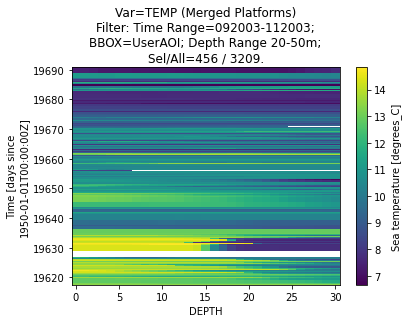

In [28]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
    
    merged_arr[var] = xr.merge([data_var_dict[pc][var] for pc in data_dict.keys()])  
        
    title = f'Var={var} (Merged Platforms)\nFilter: Time Range={time_filter_str};\nBBOX={bbox_key}; Depth Range {depth1}-{depth2}m;\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)
    display(merged_arr[var])

### Create Dataframe of Filtered XARRAY
This step is implemented to generate a CSV-structured dataframe, to then export to a CSV file expected by the RGeostats module.


In [29]:
# Create dataframe with filtered data and columns ['LATITUDE', 'LONGITUDE', 'TIME', 'TEMP', 'DEPTH']
filtered2csv_multiDepths = pd.DataFrame() 

for pc in data_dict.keys():

    for d in range(depth1, depth2+1):

        # Create temporary dataframe
        temp = pd.DataFrame()

        data_depth_sel = data_dict[pc]['data'].isel(TIME=index_dict[pc],
                                                    LATITUDE=index_dict[pc],
                                                    LONGITUDE=index_dict[pc],
                                                    DEPTH=slice(d, d+1))

        for col in ['LONGITUDE', 'LATITUDE', 'TIME']:
            temp[col.title()] = data_depth_sel[col].data.astype(float) 
                
        if 'TEMP' in vars_sel: temp['Temperature'] = data_depth_sel['TEMP'].data.astype(float) 
        if 'CNDC' in vars_sel: temp['Conductivity'] = data_depth_sel['CNDC'].data.astype(float) 
        if 'PSAL' in vars_sel: temp['Salinity'] = data_depth_sel['PSAL'].data.astype(float) 

        temp['Depth'] = d 
        temp['Vaissel_name'] = pc 

        filtered2csv_multiDepths = filtered2csv_multiDepths.append(temp, ignore_index=True)
    
# Rename index column with 'rank'
filtered2csv_multiDepths = filtered2csv_multiDepths.rename_axis("rank")

display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vaissel_name
rank,,,,,,
0,8.1725,63.068802,19646.981389,13.196,20,AA
1,8.1345,63.105801,19647.258287,13.127,20,AA
2,8.1028,63.127300,19647.288403,13.289,20,AA
3,8.1013,63.127998,19647.566528,13.310,20,AA
4,8.3798,62.953201,19647.952778,12.878,20,AA
...,...,...,...,...,...,...
14131,6.1065,62.445301,19667.094514,10.766,50,JH
14132,5.9402,62.088299,19667.370891,10.856,50,JH
14133,5.4093,63.031502,19667.964549,9.995,50,JH


### Assign *Profil_id* to the unique positions

In [30]:
# find pair of unique coordinates 
unique_pos = filtered2csv_multiDepths.groupby(['Longitude','Latitude']).size().reset_index().rename(columns={0:'count'})

prof_id = 1
for long, lat in zip(unique_pos['Longitude'], unique_pos['Latitude']):
    
    # Define condition
    cond = (filtered2csv_multiDepths['Longitude'] == long) & (filtered2csv_multiDepths['Latitude'] == lat)
#     display(filtered2csv_multiDepths.loc[cond])
    
    # Assign unique Profil_id 
    filtered2csv_multiDepths.loc[cond,'Profil_id'] = prof_id
    prof_id += 1

# Convert to integer
filtered2csv_multiDepths = filtered2csv_multiDepths.astype({'Profil_id': int})
display(filtered2csv_multiDepths)

,Longitude,Latitude,Time,Temperature,Depth,Vaissel_name,Profil_id
rank,,,,,,,
0,8.1725,63.068802,19646.981389,13.196,20,AA,319
1,8.1345,63.105801,19647.258287,13.127,20,AA,317
2,8.1028,63.127300,19647.288403,13.289,20,AA,316
3,8.1013,63.127998,19647.566528,13.310,20,AA,315
4,8.3798,62.953201,19647.952778,12.878,20,AA,322
...,...,...,...,...,...,...,...
14131,6.1065,62.445301,19667.094514,10.766,50,JH,279
14132,5.9402,62.088299,19667.370891,10.856,50,JH,273
14133,5.4093,63.031502,19667.964549,9.995,50,JH,251


### Export to CSV

In [31]:
# Save dataframe to csv
data_output = os.path.join(os.getcwd(), 'data_output')
if not os.path.exists(data_output): os.mkdir(data_output)

csvname = os.path.join(data_output, 
                       f'Producer_pc={pc_str}_BBOX={bbox_key}_MMYYYY={str(month).zfill(2)}{year}_d={depth1}-{depth2}m_var={"_".join(vars_sel)}.csv')

filtered2csv_multiDepths.to_csv(csvname, sep=',', header=True)
print('Output filename:', csvname)

Output filename: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/Producer_pc=AA-GS-GT-HJ-JH_BBOX=UserAOI_MMYYYY=102003_d=20-50m_var=TEMP.csv


#### Plot Histogram of measurements of the given year

<AxesSubplot:xlabel='Month & Day', ylabel='Count'>

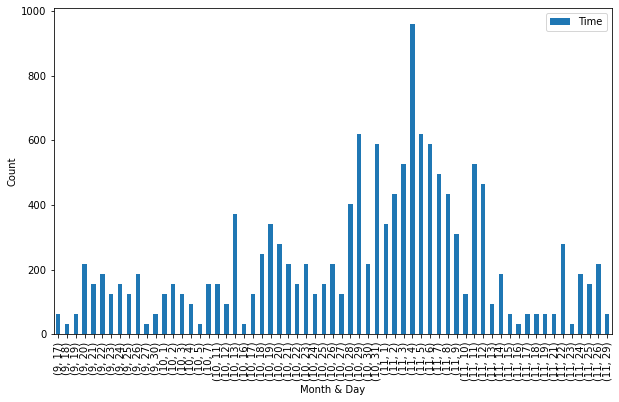

In [32]:
# Create a copy (I need to keep the original as it is, because Time needs to be a floating number)
filtered2csv_multiDepths_time = filtered2csv_multiDepths.copy()

# Convert Time from float to datetime
filtered2csv_multiDepths_time['Time'] = [start_date + timedelta(t) for t in filtered2csv_multiDepths_time.loc[:,'Time']]

# Plot Histogram
filtered2csv_multiDepths_time["Time"].groupby([filtered2csv_multiDepths_time["Time"].dt.month,
                                               filtered2csv_multiDepths_time["Time"].dt.day]).count().plot(figsize=(10,6),
                                                                                                           kind="bar", 
                                                                                                           legend=True, 
                                                                                                           xlabel='Month & Day', 
                                                                                                           ylabel='Count')

# Geostatistical Analysis with RGeostats
The aim is to generate estimation and error maps of the selected CTD physical variables (e.g. temperature, salinity) in the selected region of interest (e.g. Barents sea) from spatio-temporal data measured along vertical profiles.

In this Notebook, the variable **Temperature** is shown as an example. 

There are a number of preparatory steps to implement, which allow to fine-tuning the parameters for modelling the interpolation of the variable.

This builds on the RGeostats workshop, held in Bremen in 2019. The material is available on https://github.com/ec-intaros/RGeostats-workshop. 

## Set-up

### Install R Kernel & Testing

In [33]:
!pip install rpy2

%load_ext rpy2.ipython

### Import variables from Python

In [34]:
import rpy2.robjects as robjects

# BBOX (note it's stored as an array of format: [minLong, maxLong, minLat, maxLat, eg [30, 60, 50, 80]]
robjects.globalenv['bbox_key'] = bbox_key
robjects.globalenv['long_min'] = bbox_values[0]
robjects.globalenv['long_max'] = bbox_values[1]
robjects.globalenv['lat_min'] = bbox_values[2]
robjects.globalenv['lat_max'] = bbox_values[3]

# Time Range
robjects.globalenv['time_filter_str'] = time_filter_str

# Depth Range
robjects.globalenv['depth'] = depth
robjects.globalenv['depth1'] = depth1
robjects.globalenv['depth2'] = depth2

# Mesh
robjects.globalenv['mesh'] = mesh

# Directory and CSV Name
robjects.globalenv['data_output'] = data_output 
robjects.globalenv['csvname'] = csvname

# Variables
robjects.globalenv['vars'] = '_'.join(vars_sel) 

In [35]:
%%R
# Check Variables
print('Printing variables imported from Python script')
cat('bbox_key:', bbox_key, '\n')
long_lim   = c(long_min, long_max)
lat_lim    = c(lat_min, lat_max)
cat('long_lim:', long_lim, '\n')
cat('lat_lim:', lat_lim, '\n')
cat('time_filter_str:', time_filter_str, '\n')
cat('depth:', depth, '\n')
cat('depth1:', depth1, '\n')
cat('depth2:', depth2, '\n')
cat('mesh:', mesh, '\n')
cat('data_output:', data_output, '\n')
cat('csvname:', csvname, '\n')
cat('vars:', vars, '\n')

[1] "Printing variables imported from Python script"
bbox_key: UserAOI 
long_lim: -4 18 
lat_lim: 42 72 
time_filter_str: 092003-112003 
depth: 50 
depth1: 20 
depth2: 50 
mesh: 1 
data_output: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output 
csvname: /workspace/INTAROS/iaos-showcase-app-Barents-Sea-CTD/data_output/Producer_pc=AA-GS-GT-HJ-JH_BBOX=UserAOI_MMYYYY=102003_d=20-50m_var=TEMP.csv 
vars: TEMP 


### Definition of the environment

The next cells have specific contents for loading the library **RIntaros** that the user must choose to run or to skip. Their order is important.

In [36]:
%%R 
suppressWarnings(suppressPackageStartupMessages(library(RIntaros)))

# Defining if the data set must be read or not from the CSV (flag.read)
flag.read = FALSE

## Loading Data

In [37]:
%%R 
# Setup OUR environment and datasets 
dir.name   = getwd()
data.name  = basename(data_output)
file.name  = basename(csvname)

intaros.save.environ(long_lim = long_lim, lat_lim = lat_lim,
                     flag_file = FALSE)

var = "Temperature"

Then we read the **CSV** file (taking the header line into account) and create the RGeostats Db. Finally we show the contents of the newly created Db (named **db0**).

In [38]:
%%R 
if (flag.read || ! exists("db0")) db0 = imr_read_csv(file.path(dir.name,data.name,file.name))
db0


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of fields             = 7
Maximum Number of attributes = 7
Total number of samples      = 14136

Variables
---------
Field =   1 - Name    =  rank - Locator =  NA
Field =   2 - Name    =  Longitude - Locator =  x1
Field =   3 - Name    =  Latitude - Locator =  x2
Field =   4 - Name    =  Time - Locator =  NA
Field =   5 - Name    =  Temperature - Locator =  NA
Field =   6 - Name    =  Depth - Locator =  NA
Field =   7 - Name    =  Profil_id - Locator =  NA


## Dataset Global Statistics

Generate global statistics of the dataset.

In [39]:
%%R
years      = subyears = get_db_limits_year(db0)
colyears   = rg.colors(length(years))
print('Let us get some statistics on the information available:')
cat(build_title("The dataset period is:",time2date(get_db_limits_time(db0))))
print('')
db.stat.print(db0,funs=c("num","mini","maxi","mean"),
              names=c("Longitude","Latitude","Depth","Temperature"))#,"Conductivity","Salinity"))

[1] "Let us get some statistics on the information available:"
The dataset period is: (2003-09-17 => 2003-11-29)[1] ""
               Number   Minimum   Maximum      Mean
Longitude       14136    -3.686    17.969     5.963
Latitude        14136    56.719    70.438    61.882
Depth           14136    20.000    50.000    35.000
Temperature     13966     6.657    14.835    10.401



## Studying variable **Temperature**

### Display Measurement Locations

We display the filtered samples focusing on the variable in a 2D aerial view, reporting the country borders. For comparison, we define a common color scale, established on the global minimum and maximum values (**var_scale0**).

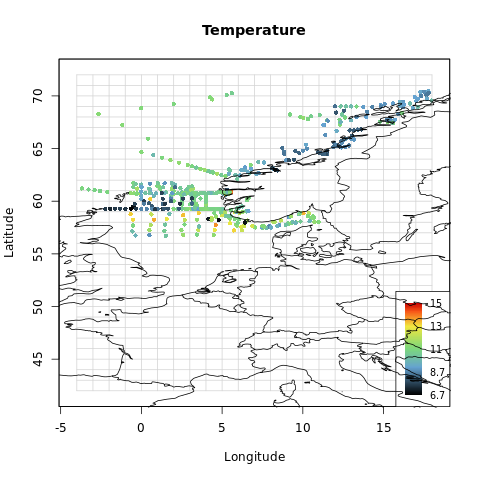

In [46]:
%%R
colors.temp = rg.colors(rank=1)
var_scale0 = get_db_limits_var(db0,var)
display_var(db0, var = var, colors = colors.temp, title = var, filename = var, pos.legend=1)

### Block Average at the given Depth

The next display considers the variable averaged over the cells of a coarse grid, given as the input parameter **mesh**.

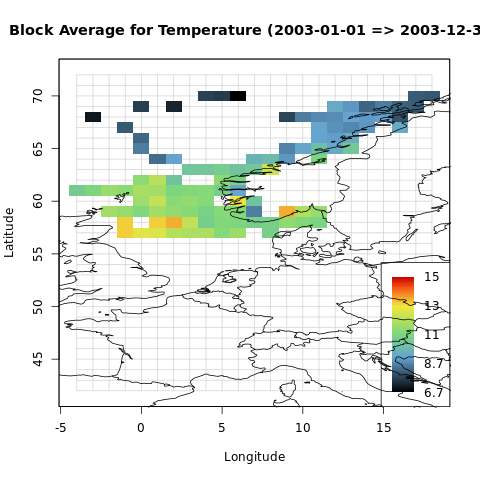

In [47]:
%%R
var = "Temperature"

depth_lim=c(depth1,depth2)

# Select samples and set the color scale
db1       = apply_sel(db0, depth_lim=depth_lim,compress = TRUE)
var_scale = get_db_limits_var(db1,var)

# Comment the following line if you want to to display all years
subyears = years[1]

date_lim  = create_limits_date(years[1])
db        = apply_sel(db1, date_lim=date_lim)
filename  = paste0(var,"_Mean_",years[1])
title     = paste("Block Average for", build_title(var, date_lim))
dbg       = stats_grid(db, var, fun = "mean", mesh = 1)
display_stats(dbg, var, var_scale = var_scale, colors = colors.temp,
            title = title, filename = filename, pos.legend=1)

### Histogram of Measurement Depths

We plot the histogram of measurements in the selected time range.

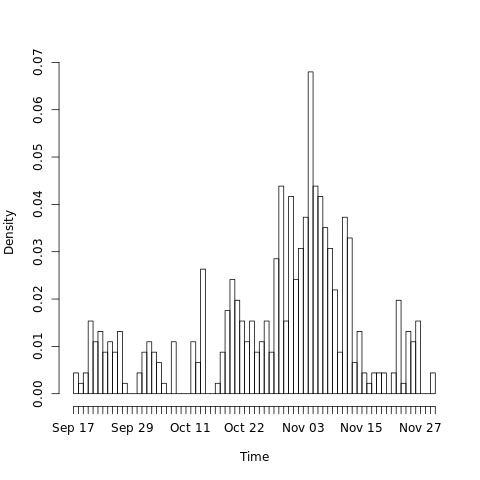

In [42]:
%%R
# Histogram of measurements over time
hist(time2date(db0[,"Time"]),breaks=100,xlab="Time",main="")

### Horizontal Variogram per Year

Review the horizontal variograms for different years at a given depth, calculated from the aggregated data set.

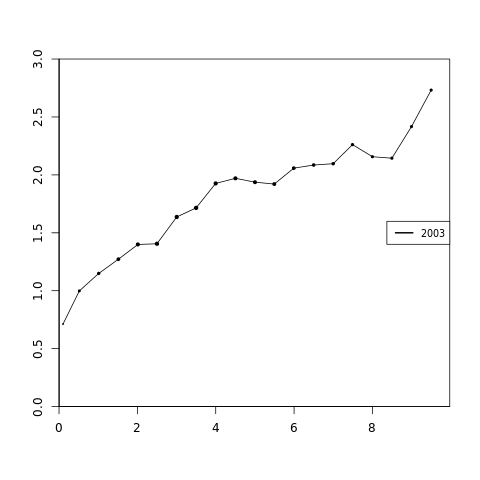

In [43]:
%%R
# Define the active samples
dbr       = db.locate(db0,var,"z")

# Variogram parameters
vario_lag  = 0.5
vario_nlag = 20
varmax = 3

# Loop on the years
ecr = 1
add = FALSE
for (year in years) 
{
  date_lim = create_limits_date(year)
  dbr = remove_sel(dbr)
  dbr = apply_sel(dbr, date_lim = date_lim)

  vario = prepar_vario(dbr, dirvect=NA, 
                       vario_lag = vario_lag, vario_nlag = vario_nlag, draw.vario=TRUE,
                       add=add, ylim=c(0,varmax), col=colyears[ecr], lwd=1,
                       varline=FALSE, npairdw=TRUE)

  ecr = ecr + 1
  add = TRUE
}
legend("right",legend=years,col=colyears,lty=1,lwd=2,cex=0.8)

### Cross-Validation
We perform a cross-validation step to estimate the cross-validation Standard Error of the model.


Cross-Validation Scores
-----------------------
                             Number      Mean  Variance
Xvalid.Temperature.esterr       445     0.004     0.620
Xvalid.Temperature.stderr       445     0.002     0.936



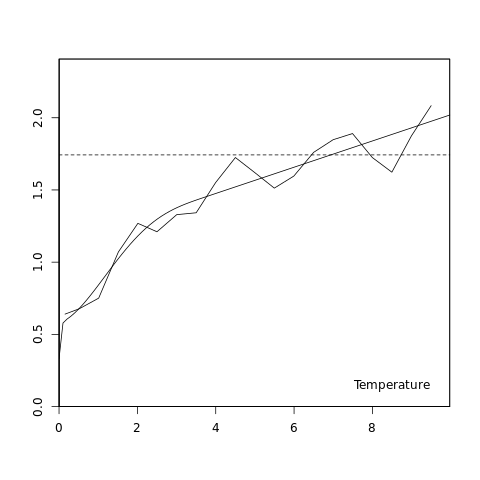

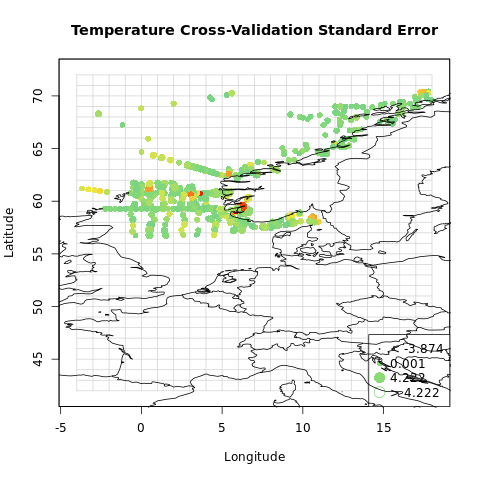

In [48]:
%%R 
# Define the active samples
date_lim  = create_limits_date(year) 

# Variogram parameters
vario_lag  = vario_lag #0.5
vario_nlag = vario_nlag #20

# Perform the Cross-validation (includes Variogram calculation and Model fitting)
dbp = xvalid_2D(dbr, var,  
                vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                dirvect = NA, draw.model=TRUE, radix="Xvalid")
db.stat.print(dbp,names="Xvalid*",funs=c("num","mean","var"),title="Cross-Validation Scores")

# Display the results
filename  = paste0("Xvalid_",var)
display_var(dbp, var = "*stderr", flag.xvalid = TRUE,
            title = paste(var, 'Cross-Validation Standard Error'), filename = filename, pos.legend=1)

### 2-D Estimation of Temperature

We interpolate the Temperature for the given bounding box, at the given depth, and given time interval.

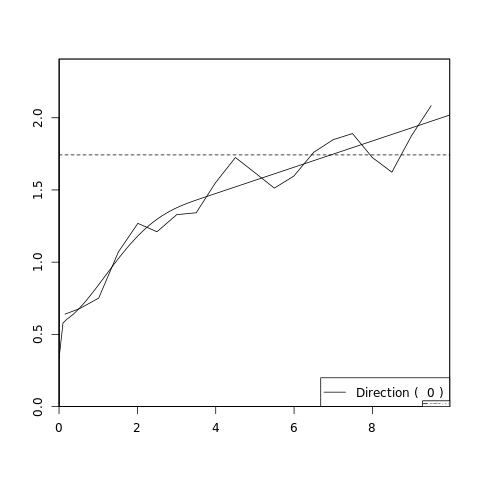

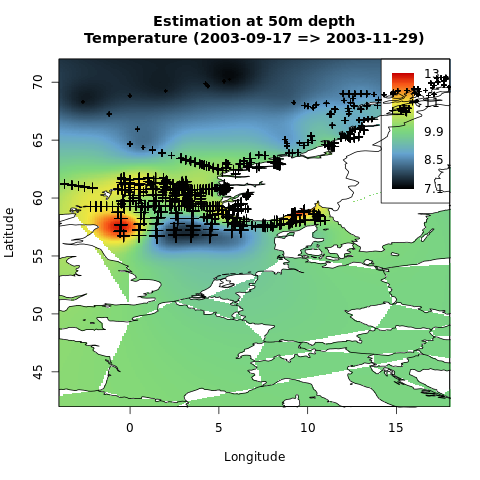

In [45]:
%%R 
# Select the active samples
# depth = 20 # By default it uses the one selected by the user at the start of the notebook

# Variogram parameters
vario_lag  = vario_lag # 0.5
vario_nlag = vario_nlag # 20

# Perform the interpolation (includes Variogram calculation and Model fitting)
dbg = interpolate_2D(db0, var, mesh = mesh/10, moving=FALSE,
                     vario_lag = vario_lag, vario_nlag = vario_nlag, struct = c(1,3,5,12), 
                     dirvect = NA, draw.model=TRUE, pos.legend=1)

# Display the results
filename  = paste0(var,".Estim2D_Year_",year)
display_result(db0, dbg, var = var, depth = depth, flag.estim = TRUE, 
               colors = colors.temp, filename = filename, pos.legend=7)